In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import json
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal
import cvxpy as cvx

np.random.seed(12) 

In [2]:
%load_ext autoreload
%autoreload 2

# Create data

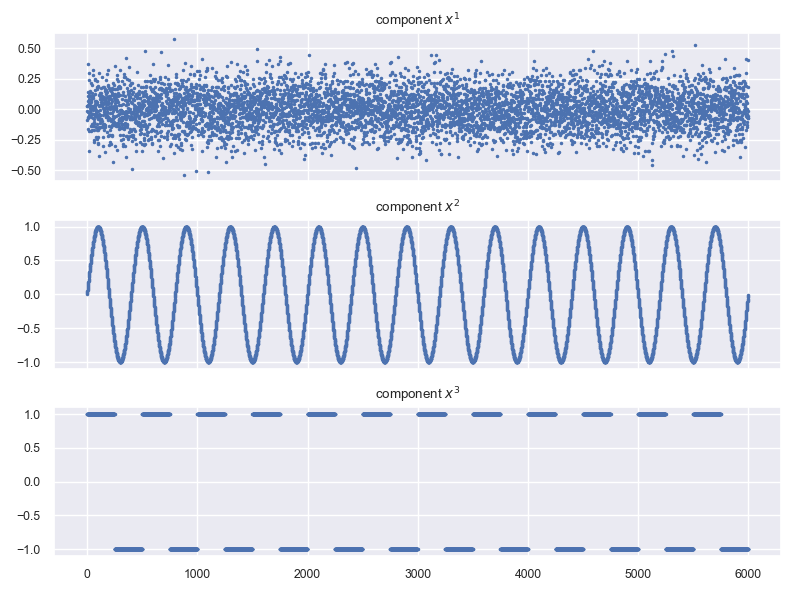

In [22]:
period_seas = 400

t = np.arange(period_seas*15)

signal1 = 0.15 * np.random.randn(len(t))
signal2 = np.sin(2 * np.pi * t * 1 / (period_seas))  
signal3 = signal.square(2 * np.pi * t * 1 / (500.)) 

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
signal_large = np.sum(X_real, axis=0)

plot_decomp(X_real)

In [4]:
signal_small = signal_large[:int(period_seas)*1]
signal_medium = signal_large[:int(period_seas)*5]

# Define SD problem

In [15]:
def l2_l1d1_l2d2periodic(
    signal,
    weight_s_hat,
    weight_s_seas,
    l2="norm", # or "sumsquares"
    scale=False,
    period=period_seas,
    solver="MOSEK"
):
    l2_func = {"norm" : cvx.norm,
               "sumsquares" : cvx.sum_squares
              }
    
    scale_err = 1/len(signal) if scale else 1
    
    s_seas = cvx.Variable(len(signal))
    s_hat = cvx.Variable(len(signal))
    s_error = cvx.Variable(len(signal))
    weight_s_hat = cvx.Constant(value=weight_s_hat)
    weight_s_seas = cvx.Constant(value=weight_s_seas)
    scale_err = cvx.Constant(value=scale_err)

    objective = cvx.Minimize(
        scale_err * l2_func[l2](s_error)
      + weight_s_hat *  cvx.norm1(cvx.diff(s_hat, k=1))
      + weight_s_seas * l2_func[l2](cvx.diff(s_seas, k=2))
    )

    # Consistency and periodicity constraints
    constraints = [
        signal == s_hat + s_seas + s_error,
        cvx.sum(s_seas[:period]) == 0
    ]

    if len(signal) > np.max([500, period]):
        constraints.append(s_seas[period:] - s_seas[:-period] == 0)
        constraints.append(s_hat[500:] - s_hat[:-500] == 0)

    problem = cvx.Problem(objective=objective, constraints=constraints)
    problem.solve(solver=solver)
    
    return s_seas.value, s_hat.value, s_error.value, problem.objective.value

# Check reference decomposition

In [6]:
l = len(signal_medium)

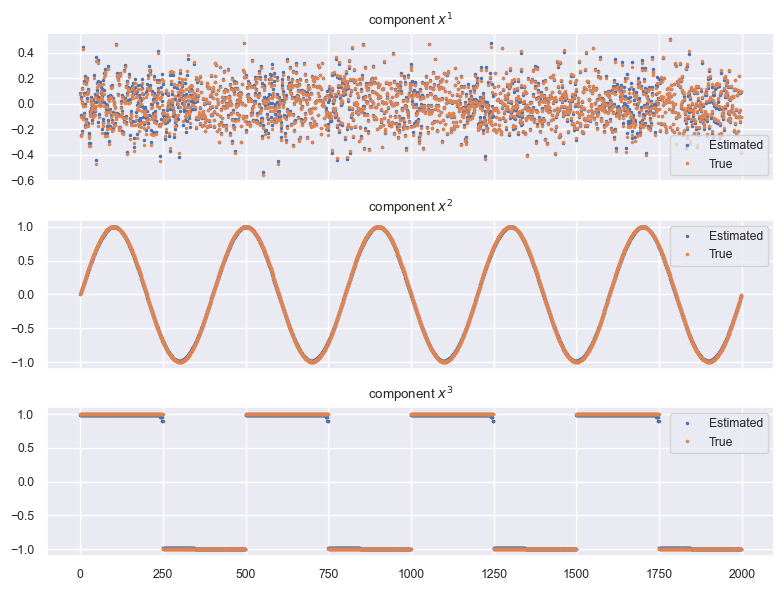

In [11]:
s_seas, s_hat, s_err, obj = l2_l1d1_l2d2periodic(signal_medium, weight_s_hat=0.11429, weight_s_seas=64.75, l2="norm", scale=False)
plot_decomp([s_err, s_seas, s_hat], [x[:l] for x in X_real])

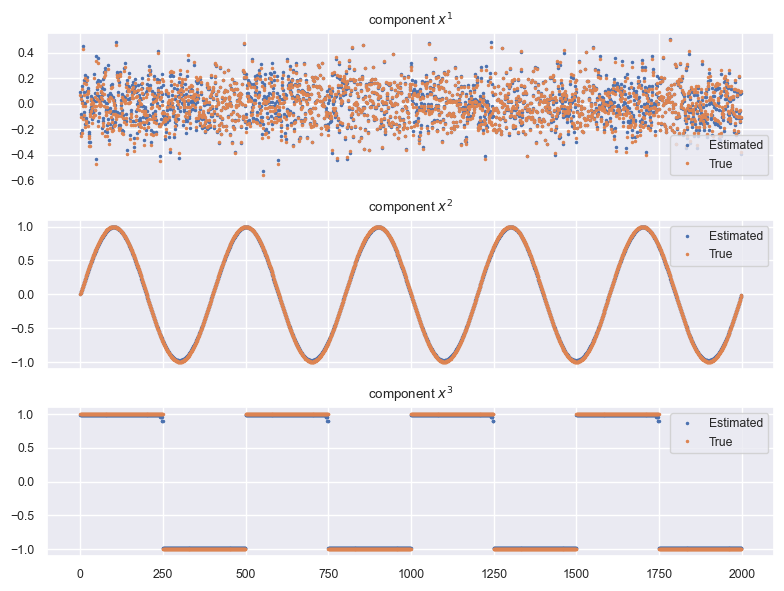

In [19]:
s_seas, s_hat, s_err, obj = l2_l1d1_l2d2periodic(signal_medium, weight_s_hat=0.11429e-3, weight_s_seas=64.75e-3, l2="norm", scale=True)
plot_decomp([s_err, s_seas, s_hat], [x[:l] for x in X_real])

# Run comparison

In [62]:
results = {}
weight_seas_iter = np.logspace(1.5, 3.5, 12)
weight_hat_iter = np.logspace(-4, 3, 12)
# np.logspace(1.5, 3.5, 12)
# np.logspace(-4, 3, 12)

In [160]:
def run(sig, run_type, scale, plot=False, skip_l1d1_scale=False):
    results[run_type] = {}
    
    # # get original decomposition
    # s_seas, s_hat, s_err, obj = l2_l1d1_l2d2periodic(sig, weight_s_hat=1, weight_s_seas=10, l2="norm",
    #                                                  scale=scale, skip_l1d1_scale=skip_l1d1_scale)
    # results[run_type]["norm"] = {"s_seas": s_seas, "s_hat": s_hat, "s_err": s_err, "obj": obj} 

    # results with sum_squares
    min_w_seas, min_w_shat = 1, 1
    rmse_s_seas_list, mae_s_hat_list = [], []
    w_shat_min, w_seas_min = 0, 0
    
    for i,w1 in tqdm(enumerate(weight_hat_iter)):
        mae_list, mse_list = [], []
        for j,w2 in enumerate(weight_seas_iter):
            s_seas_ss, s_hat_ss, _, _ = l2_l1d1_l2d2periodic(sig, weight_s_hat=w1, weight_s_seas=w2, l2="sumsquares", scale=scale)
            a = mse(signal2[:len(sig)], s_seas_ss, squared=False)
            b = mae(signal3[:len(sig)], s_hat_ss)
            mse_list.append(a)
            mae_list.append(b)
            if a<=min_w_seas and b<=min_w_shat:
                min_w_seas = a
                min_w_shat = b
                w_shat_min, w_seas_min = w1, w2
        mae_s_hat_list.append(mae_list)
        rmse_s_seas_list.append(mse_list)
        
    results[run_type]["mae_s_hat_list"] = mae_s_hat_list
    results[run_type]["rmse_s_seas_list"] = rmse_s_seas_list
    results[run_type]["min_shat_seas"] = (w_shat_min, w_seas_min)
    print(run_type, results[run_type]["min_shat_seas"])

In [161]:
# Small len without scaling
run(signal_small, "Small Len.", scale=False)

# Medium len without scaling
run(signal_medium, "Med. Len.", scale=False)

# Large len without scaling
run(signal_large, "Large Len.", scale=False)

# Small len with scaling
run(signal_small, "Small Len. Scaled", scale=True)

# Medium len with scaling
run(signal_medium, "Med. Len. Scaled", scale=True)

# Large len with scaling
run(signal_large, "Large Len. Scaled", scale=True)

12it [00:09,  1.30it/s]


Small Len. (0.6579332246575682, 900.6280202112786)


12it [00:22,  1.85s/it]


Med. Len. (2.848035868435799, 3162.2776601683795)


12it [00:48,  4.08s/it]


Large Len. (0.6579332246575682, 1368.874509537082)


12it [00:08,  1.38it/s]


Small Len. Scaled (0.008111308307896872, 592.5530975545674)


12it [00:22,  1.91s/it]


Med. Len. Scaled (0.0001, 31.622776601683793)


12it [00:50,  4.20s/it]

Large Len. Scaled (0.0001, 31.622776601683793)


## RMSE of seasonal component results 

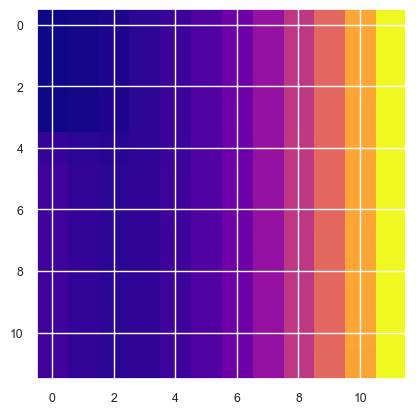

In [197]:
plt.imshow(np.matrix(m), cmap="plasma") # each row is w_seas 

Small Len. (0.6579332246575682, 900.6280202112786)
Med. Len. (2.848035868435799, 3162.2776601683795)
Large Len. (0.6579332246575682, 1368.874509537082)
Small Len. Scaled (0.008111308307896872, 592.5530975545674)
Med. Len. Scaled (0.0001, 31.622776601683793)
Large Len. Scaled (0.0001, 31.622776601683793)


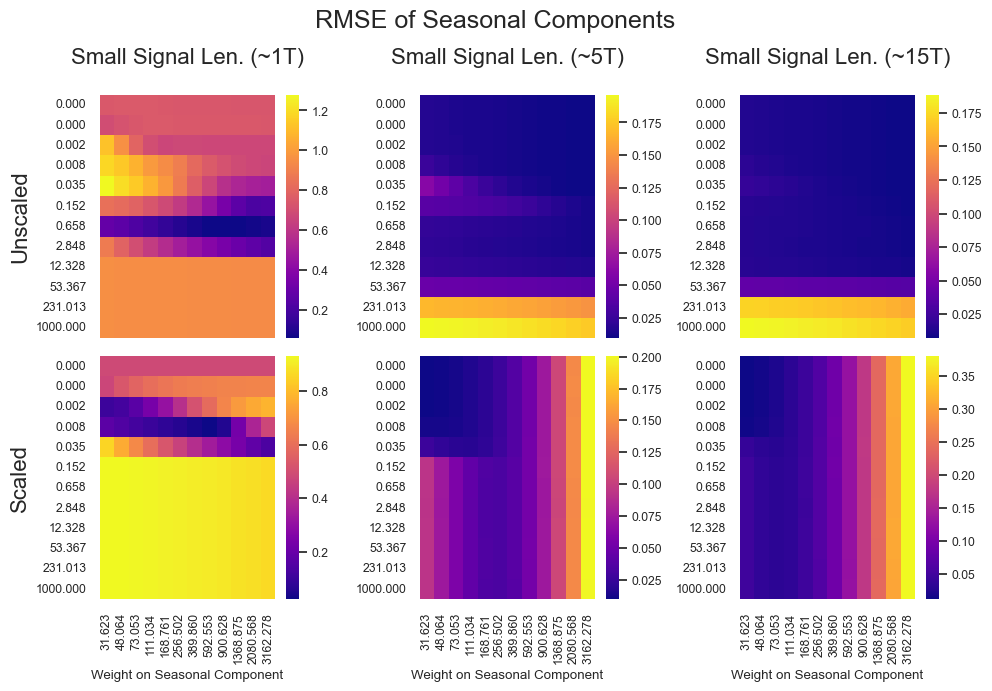

In [218]:
f, ax = plt.subplots(2,3, sharex=True, figsize=(10,7))

keys = list(results.keys())

x_axis_labels = ['{:.3f}'.format(x) for x in weight_seas_iter]
y_axis_labels = ['{:.3f}'.format(x) for x in weight_hat_iter]


for i,ax_ in enumerate(ax):
    for ax__, k in zip(ax_, keys):
        m = results[k]["rmse_s_seas_list"]
        g = sns.heatmap(m, cmap="plasma", ax=ax__, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        print(k, results[k]["min_shat_seas"])
        
        # mins = {"hat": [results[k]["min_shat_seas"][0]], "seas": [results[k]["min_shat_seas"][1]]}
        # df = pd.DataFrame(mins)
        # sns.lineplot(df, x="seas", y="hat", ax=ax__, markers=True)
        if i==1:
            ax__.set_xlabel('Weight on Seasonal Component')
        
    keys = keys[3:]

ax[0][0].set_ylabel(r"Unscaled", fontsize=16)
ax[1][0].set_ylabel("Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)\n", fontsize=16)
ax[0][1].set_title("Small Signal Len. (~5T)\n", fontsize=16)
ax[0][2].set_title("Small Signal Len. (~15T)\n", fontsize=16)


f.suptitle("RMSE of Seasonal Components", fontsize=18)
plt.tight_layout()
plt.show()

# weight_seas_iter = np.logspace(1.5, 3.5, 12)
# weight_hat_iter = np.logspace(-4, 3, 12)

# each column is a weight_seas value
# each row is a weight_hat value, top to bottom

## MAE of piecewise constant results

Small Len. (0.6579332246575682, 900.6280202112786)
Med. Len. (2.848035868435799, 3162.2776601683795)
Large Len. (0.6579332246575682, 1368.874509537082)
Small Len. Scaled (0.008111308307896872, 592.5530975545674)
Med. Len. Scaled (0.0001, 31.622776601683793)
Large Len. Scaled (0.0001, 31.622776601683793)


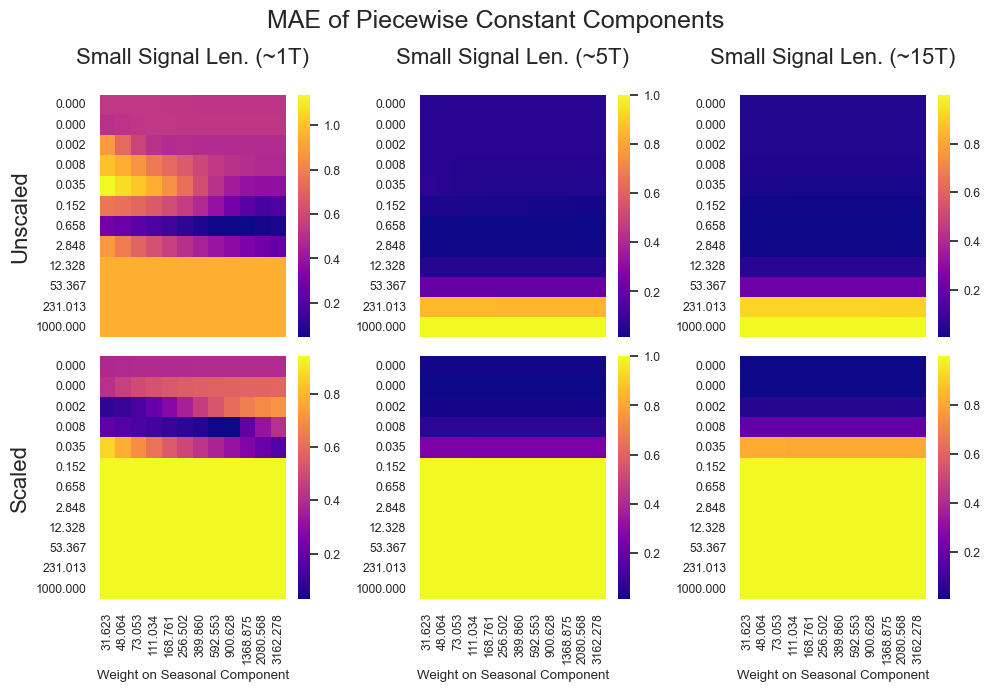

In [217]:
f, ax = plt.subplots(2,3, sharex=True, figsize=(10,7))

keys = list(results.keys())

x_axis_labels = ['{:.3f}'.format(x) for x in weight_seas_iter]
y_axis_labels = ['{:.3f}'.format(x) for x in weight_hat_iter]


for i,ax_ in enumerate(ax):
    for ax__, k in zip(ax_, keys):
        print(k, results[k]["min_shat_seas"])
        m = results[k]["mae_s_hat_list"]
        s = sns.heatmap(m, cmap="plasma", ax=ax__, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
        if i==1:
            s.set(xlabel='Weight on Seasonal Component')
    keys = keys[3:]

ax[0][0].set_ylabel(r"Unscaled", fontsize=16)
ax[1][0].set_ylabel("Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)\n", fontsize=16)
ax[0][1].set_title("Small Signal Len. (~5T)\n", fontsize=16)
ax[0][2].set_title("Small Signal Len. (~15T)\n", fontsize=16)


f.suptitle("MAE of Piecewise Constant Components", fontsize=18)
plt.tight_layout()
plt.show()

In [231]:
runs = ['Small Len.', 'Med. Len.', 'Large Len.', 'Small Len. Scaled', 'Med. Len. Scaled', 'Large Len. Scaled']

# unscaled
w1, w2  = 2.848035868435799, 3162.2776601683795

results[runs[0]]["s_seas_med"] , results[runs[0]]["s_hat_med"], _, _ = l2_l1d1_l2d2periodic(signal_small,
                                                                                         weight_s_hat=w1, 
                                                                                         weight_s_seas=w2,
                                                                                         l2="sumsquares", 
                                                                                         scale=False)

results[runs[1]]["s_seas_med"] , results[runs[1]]["s_hat_med"], _, _ = l2_l1d1_l2d2periodic(signal_medium,
                                                                                         weight_s_hat=w1, 
                                                                                         weight_s_seas=w2,
                                                                                         l2="sumsquares", 
                                                                                         scale=False)

results[runs[2]]["s_seas_med"] , results[runs[2]]["s_hat_med"], _, _ = l2_l1d1_l2d2periodic(signal_large,
                                                                                         weight_s_hat=w1,
                                                                                         weight_s_seas=w2,
                                                                                         l2="sumsquares", 
                                                                                         scale=False)

                 
# scaled
w1_s, w2_s = 0.0001, 31.622776601683793

results[runs[3]]["s_seas_med"] , results[runs[3]]["s_hat_med"], _, _ = l2_l1d1_l2d2periodic(signal_small,
                                                                                         weight_s_hat=w1_s, 
                                                                                         weight_s_seas=w2_s,
                                                                                         l2="sumsquares", 
                                                                                         scale=True)

results[runs[4]]["s_seas_med"] , results[runs[4]]["s_hat_med"], _, _ = l2_l1d1_l2d2periodic(signal_medium,
                                                                                         weight_s_hat=w1_s, 
                                                                                         weight_s_seas=w2_s,
                                                                                         l2="sumsquares", 
                                                                                         scale=True)

results[runs[5]]["s_seas_med"] , results[runs[5]]["s_hat_med"], _, _ = l2_l1d1_l2d2periodic(signal_large,
                                                                                         weight_s_hat=w1_s, 
                                                                                         weight_s_seas=w2_s,
                                                                                         l2="sumsquares", 
                                                                                         scale=True)

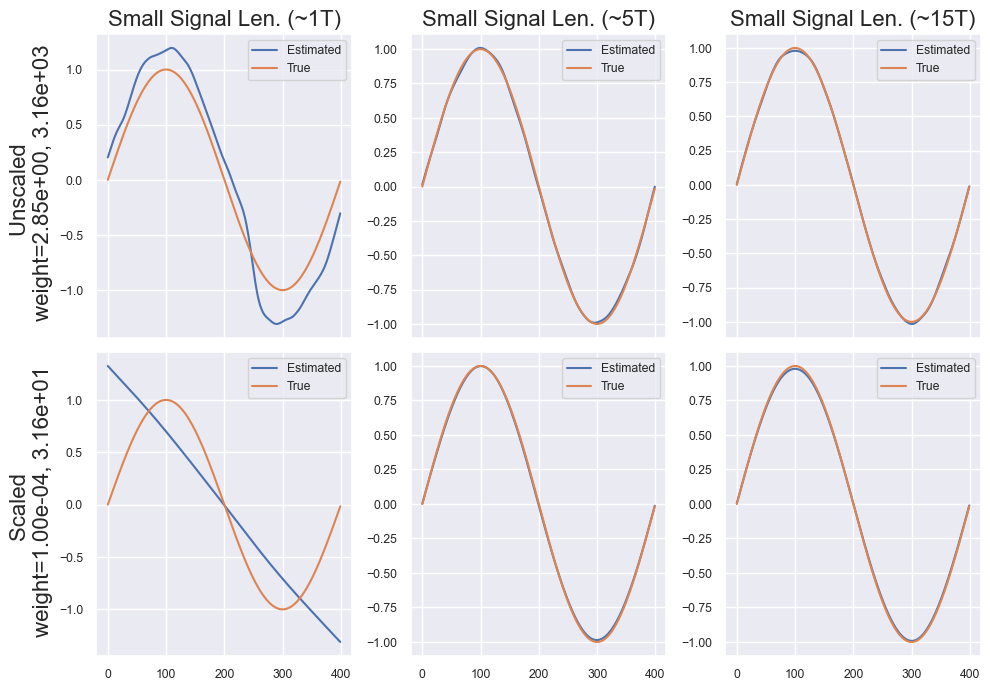

In [232]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = list(results.keys())

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        ax__.plot(results[k]["s_seas_med"][:400], label="Estimated")
        ax__.plot(signal2[:400], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled \n weight={w1:.2e}, {w2:.2e}", fontsize=16)
ax[1][0].set_ylabel(f"Scaled \n weight={w1_s:.2e}, {w2_s:.2e}", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Small Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Small Signal Len. (~15T)", fontsize=16)

plt.tight_layout()

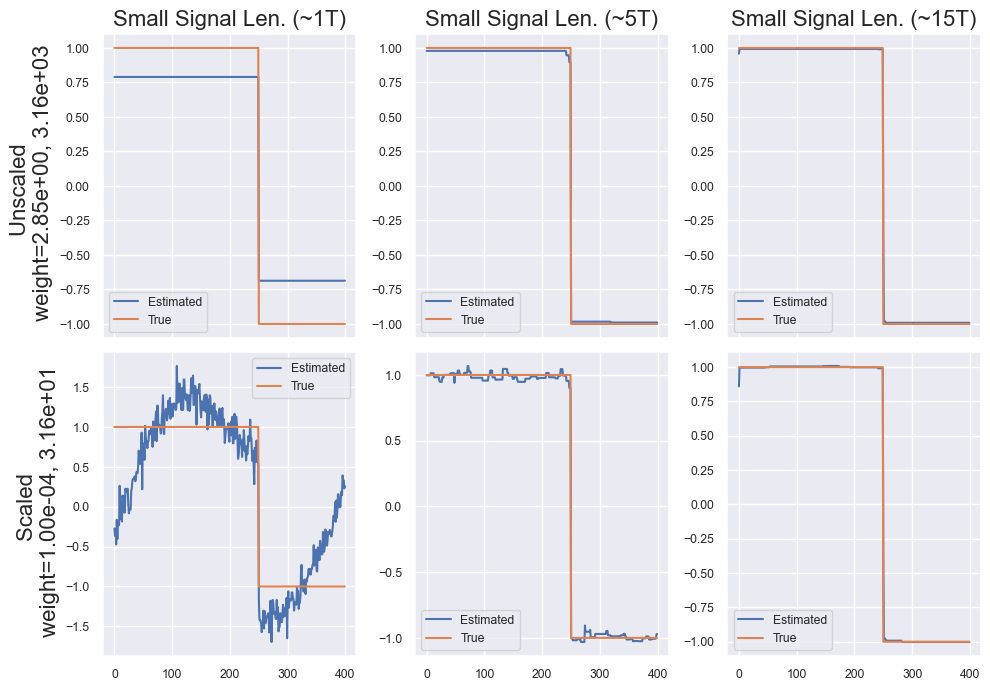

In [233]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = list(results.keys())

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        ax__.plot(results[k]["s_hat_med"][:400], label="Estimated")
        ax__.plot(signal3[:400], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled \n weight={w1:.2e}, {w2:.2e}", fontsize=16)
ax[1][0].set_ylabel(f"Scaled \n weight={w1_s:.2e}, {w2_s:.2e}", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Small Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Small Signal Len. (~15T)", fontsize=16)

plt.tight_layout()

# Plot composition to check

Original

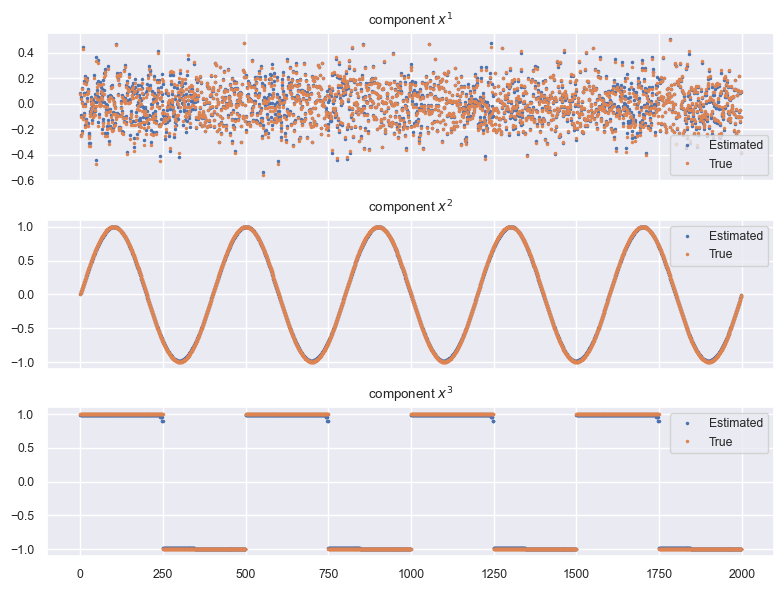

In [121]:
l = len(signal_medium)
s_seas, s_hat, s_err, obj = l2_l1d1_l2d2periodic(signal_medium, weight_s_hat=0.11429, weight_s_seas=64.75, l2="norm", scale=True, skip_l1d1_scale=False)
plot_decomp([s_err, s_seas, s_hat], [x[:l] for x in X_real])

Sumsquares L2 scaled only

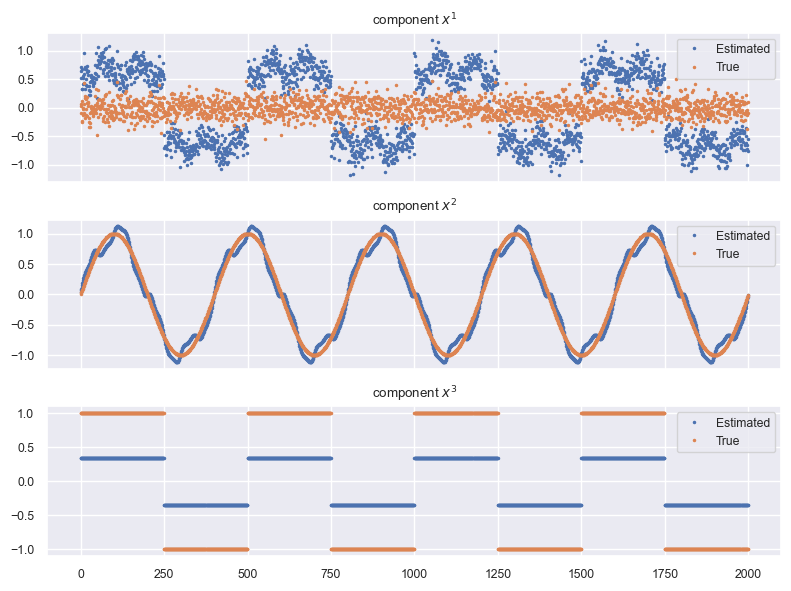

In [120]:
l = len(signal_medium)
s_seas, s_hat, s_err, obj = l2_l1d1_l2d2periodic(signal_medium, weight_s_hat=0.09, weight_s_seas=500, l2="sumsquares", scale=True, skip_l1d1_scale=True)
plot_decomp([s_err, s_seas, s_hat], [x[:l] for x in X_real])

Sumsquares scaled

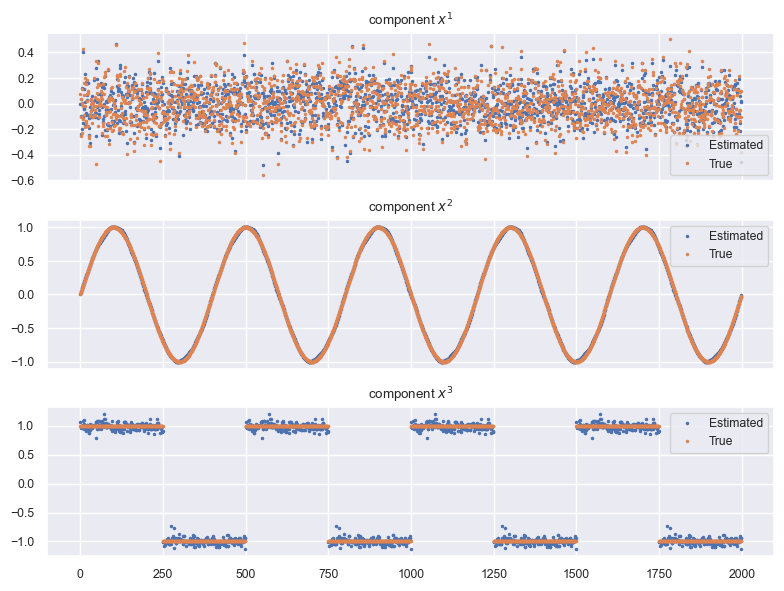

In [118]:
l = len(signal_medium)
s_seas, s_hat, s_err, obj = l2_l1d1_l2d2periodic(signal_medium, weight_s_hat=0.05, weight_s_seas=500, l2="sumsquares", scale=True)
plot_decomp([s_err, s_seas, s_hat], [x[:l] for x in X_real])